In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-05-19 03:55:55.171609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 03:55:55.171719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 03:55:55.298487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/df-test/df_test.csv
/kaggle/input/df-train/df_train.csv


In [2]:
from sklearn.model_selection import train_test_split
import csv
from tensorflow.keras.layers import Dense, SimpleRNN, InputLayer, Embedding,LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt

In [3]:
tf.random.set_seed(42)

In [4]:
df_test = pd.read_csv("/kaggle/input/df-test/df_test.csv",sep=";")
df_train = pd.read_csv('/kaggle/input/df-train/df_train.csv', sep=';')


In [5]:
df_train

Id                                               Data  \
0        0  4814,4814,6010,6011,4814,6011,6011,4814,6011,6...   
1        1  6011,6011,6011,6011,6011,6011,6011,4814,4814,4...   
2        2  8021,6011,6011,6010,4829,4814,6011,6011,6011,6...   
3        3  4814,6011,4814,4814,4814,6011,6011,5691,5691,5...   
4        4  4814,4814,4814,4814,4814,4814,5946,4814,4814,6...   
...    ...                                                ...   
7028  7028  6010,4829,6011,6011,6011,6010,6011,6011,6011,4...   
7029  7029  4814,5699,5641,5411,6010,6011,4814,6011,6011,5...   
7030  7030  6011,6011,6011,6011,6011,6011,6011,6011,6011,6...   
7031  7031  4814,4814,5411,6011,6011,4814,4814,4814,5411,6...   
7032  7032  6011,6011,6011,6011,5541,4814,6011,6011,5541,5...   

                                                 Target  
0     4814,4814,4814,4814,5411,4814,4814,4814,4814,4814  
1     4814,6011,4814,6011,4814,4814,6011,4814,6011,4814  
2     6011,6011,6010,4829,4829,6010,6011,6011,4814,6011  
3     6011,6011,6010,6011,6011,4814,4814,6011,4814,4814  
4     5499,6011,4814,4829,5200,5411,5499,5912,5411,5912  
...                                                 ...  
7028  4814,5499,5499,5411,5251,4814,5499,5499,5251,5499  
7029  6011,5261,6011,5261,4814,5411,4814,6011,5411,4814  
7030  6011,6011,6011,6011,6011,6011,6011,6011,6011,6011  
7031  4814,6011,6011,5999,5999,6011,6011,6010,4829,6011  
7032  6011,4829,6010,6011,6011,5411,6011,5541,6010,4814  

[7033 rows x 3 columns]

In [6]:
df_train_tr=pd.DataFrame()

In [7]:
df_train_tr

Empty DataFrame
Columns: []
Index: []

In [8]:
df_train["Target"]=df_train["Target"].apply(lambda x : ","+x)

In [9]:
df_train_tr["Data"]=df_train["Data"]+df_train["Target"]

In [10]:
df_train_tr

Data
0     4814,4814,6010,6011,4814,6011,6011,4814,6011,6...
1     6011,6011,6011,6011,6011,6011,6011,4814,4814,4...
2     8021,6011,6011,6010,4829,4814,6011,6011,6011,6...
3     4814,6011,4814,4814,4814,6011,6011,5691,5691,5...
4     4814,4814,4814,4814,4814,4814,5946,4814,4814,6...
...                                                 ...
7028  6010,4829,6011,6011,6011,6010,6011,6011,6011,4...
7029  4814,5699,5641,5411,6010,6011,4814,6011,6011,5...
7030  6011,6011,6011,6011,6011,6011,6011,6011,6011,6...
7031  4814,4814,5411,6011,6011,4814,4814,4814,5411,6...
7032  6011,6011,6011,6011,5541,4814,6011,6011,5541,5...

[7033 rows x 1 columns]

In [11]:
df_full=pd.concat([df_train_tr,df_test])

In [12]:
df_full

Data      Id
0     4814,4814,6010,6011,4814,6011,6011,4814,6011,6...     NaN
1     6011,6011,6011,6011,6011,6011,6011,4814,4814,4...     NaN
2     8021,6011,6011,6010,4829,4814,6011,6011,6011,6...     NaN
3     4814,6011,4814,4814,4814,6011,6011,5691,5691,5...     NaN
4     4814,4814,4814,4814,4814,4814,5946,4814,4814,6...     NaN
...                                                 ...     ...
7028  4814,5499,5311,5977,5499,5812,5311,5499,6011,5...  7028.0
7029  5411,5411,6011,5912,5691,5411,5411,5411,5411,5...  7029.0
7030  5541,5499,5499,5499,5541,5541,6011,6011,5541,6...  7030.0
7031  6011,6011,4814,4814,6011,4814,4814,6011,6011,6...  7031.0
7032  6011,4829,4814,4829,5411,5411,5661,5411,4829,4...  7032.0

[14066 rows x 2 columns]

In [13]:
df_full=df_full.reset_index().drop(["index","Id"],axis=1)

In [14]:
df_full

Data
0      4814,4814,6010,6011,4814,6011,6011,4814,6011,6...
1      6011,6011,6011,6011,6011,6011,6011,4814,4814,4...
2      8021,6011,6011,6010,4829,4814,6011,6011,6011,6...
3      4814,6011,4814,4814,4814,6011,6011,5691,5691,5...
4      4814,4814,4814,4814,4814,4814,5946,4814,4814,6...
...                                                  ...
14061  4814,5499,5311,5977,5499,5812,5311,5499,6011,5...
14062  5411,5411,6011,5912,5691,5411,5411,5411,5411,5...
14063  5541,5499,5499,5499,5541,5541,6011,6011,5541,6...
14064  6011,6011,4814,4814,6011,4814,4814,6011,6011,6...
14065  6011,4829,4814,4829,5411,5411,5661,5411,4829,4...

[14066 rows x 1 columns]

In [15]:
df_full.iloc[0]["Data"]

'4814,4814,6010,6011,4814,6011,6011,4814,6011,6011,4814,6011,4814,4814,6011,6011,4814,4814,6011,6011,6011,4814,4814,6011,6011,6011,6011,4814,4814,6011,6011,6011,6011,4814,6011,4814,4814,4814,4814,4814,6011,6011,4814,4814,4814,4814,6011,6011,6011,4814,6011,6011,4814,6011,4814,6011,6011,4814,6011,6011,4814,6011,4814,4814,4814,6011,6011,4814,6011,4814,6011,6011,6011,6011,6011,4814,5411,4814,5311,6011,6011,4814,6011,4814,6011,6011,4814,5311,4814,4814,4814,6011,5411,6011,5311,5411,6011,5411,5411,5311,5311,4814,6011,5311,5311,4814,6011,4814,5311,5311,6011,4814,4814,5411,6011,4814,4814,4814,5411,6011,6011,5411,4814,6011,4814,4814,4814,6011,4814,4814,5411,5311,6011,5311,6011,5311,6011,4814,5311,4814,5311,6011,5411,5311,5411,6011,5311,5411,5411,6011,4814,6011,4814,5311,4814,5311,4814,5921,5411,5411,6011,5311,5411,5411,4814,5311,4814,5311,4814,6011,6011,5921,4814,4814,4814,4814,5411,5411,5311,5411,5411,6011,5311,5311,6011,6011,6011,4814,4814,4814,4814,4814,5411,5311,5411,6011,5311,5411,5311,5411

In [16]:
df_full["Actual"]=df_full["Data"].apply(lambda x : list(x.split(sep=",")[-10:]))

In [17]:
df_full["Data"]=df_full["Data"].apply(lambda x : list(x.split(sep=",")[:-10]))

In [18]:
df_full

Data  \
0      [4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...   
1      [6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...   
2      [8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...   
3      [4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...   
4      [4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...   
...                                                  ...   
14061  [4814, 5499, 5311, 5977, 5499, 5812, 5311, 549...   
14062  [5411, 5411, 6011, 5912, 5691, 5411, 5411, 541...   
14063  [5541, 5499, 5499, 5499, 5541, 5541, 6011, 601...   
14064  [6011, 6011, 4814, 4814, 6011, 4814, 4814, 601...   
14065  [6011, 4829, 4814, 4829, 5411, 5411, 5661, 541...   

                                                  Actual  
0      [4814, 4814, 4814, 4814, 5411, 4814, 4814, 481...  
1      [4814, 6011, 4814, 6011, 4814, 4814, 6011, 481...  
2      [6011, 6011, 6010, 4829, 4829, 6010, 6011, 601...  
3      [6011, 6011, 6010, 6011, 6011, 4814, 4814, 601...  
4      [5499, 6011, 4814, 4829, 5200, 5411, 5499, 591...  
...                                                  ...  
14061  [5499, 5499, 5411, 5691, 5912, 5499, 5499, 541...  
14062  [5411, 5411, 5411, 5411, 5411, 5411, 5411, 541...  
14063  [5499, 6011, 5211, 5499, 5499, 5541, 5499, 591...  
14064  [5912, 6011, 6011, 5411, 5411, 5411, 4814, 601...  
14065  [6011, 6011, 6010, 5411, 4121, 4121, 5812, 601...  

[14066 rows x 2 columns]

In [19]:
X_train,X_test = train_test_split(df_full, test_size=0.2)

In [20]:
X_test

Data  \
4690   [6011, 5411, 5999, 4816, 4829, 4829, 5411, 541...   
10998  [6011, 6011, 6011, 6011, 4814, 4814, 6011, 601...   
11229  [6011, 4814, 5411, 4814, 6011, 6011, 6010, 601...   
6411   [6010, 6011, 6011, 6011, 4829, 4829, 5812, 554...   
3876   [4814, 4814, 4814, 5499, 6011, 4814, 4814, 601...   
...                                                  ...   
2811   [6011, 5411, 5411, 5691, 5499, 6011, 5499, 569...   
5720   [6011, 4814, 4814, 4814, 4814, 4814, 4814, 481...   
9918   [6011, 6011, 6011, 6011, 4814, 4814, 6011, 601...   
9710   [6011, 4814, 6011, 6011, 6011, 5691, 5621, 541...   
3000   [5411, 5499, 5499, 4814, 6011, 5261, 6011, 541...   

                                                  Actual  
4690   [4814, 6010, 4829, 5812, 4829, 6010, 5411, 412...  
10998  [5499, 5499, 5411, 4814, 5211, 6011, 5211, 549...  
11229  [6010, 5814, 5691, 6011, 5411, 6011, 6011, 541...  
6411   [5499, 4814, 6011, 5814, 6011, 6011, 6011, 601...  
3876   [4814, 4814, 5499, 5499, 4814, 4814, 5411, 481...  
...                                                  ...  
2811   [7832, 6011, 5977, 5499, 6011, 5499, 5411, 541...  
5720   [4814, 6011, 4814, 4814, 4814, 4814, 6011, 481...  
9918   [4829, 6010, 7995, 6012, 7995, 7995, 7995, 601...  
9710   [5499, 5411, 5411, 6011, 5651, 5411, 6011, 601...  
3000   [5411, 4829, 6010, 6011, 5261, 5411, 4814, 601...  

[2814 rows x 2 columns]

In [21]:

out1 = Counter(chain.from_iterable(X_train["Actual"]))
out2 = Counter(chain.from_iterable(X_train["Data"]))

In [22]:
sorted(out1, key=out1.get, reverse=True)[:5]

['6011', '4814', '5411', '4829', '6010']

<BarContainer object of 184 artists>

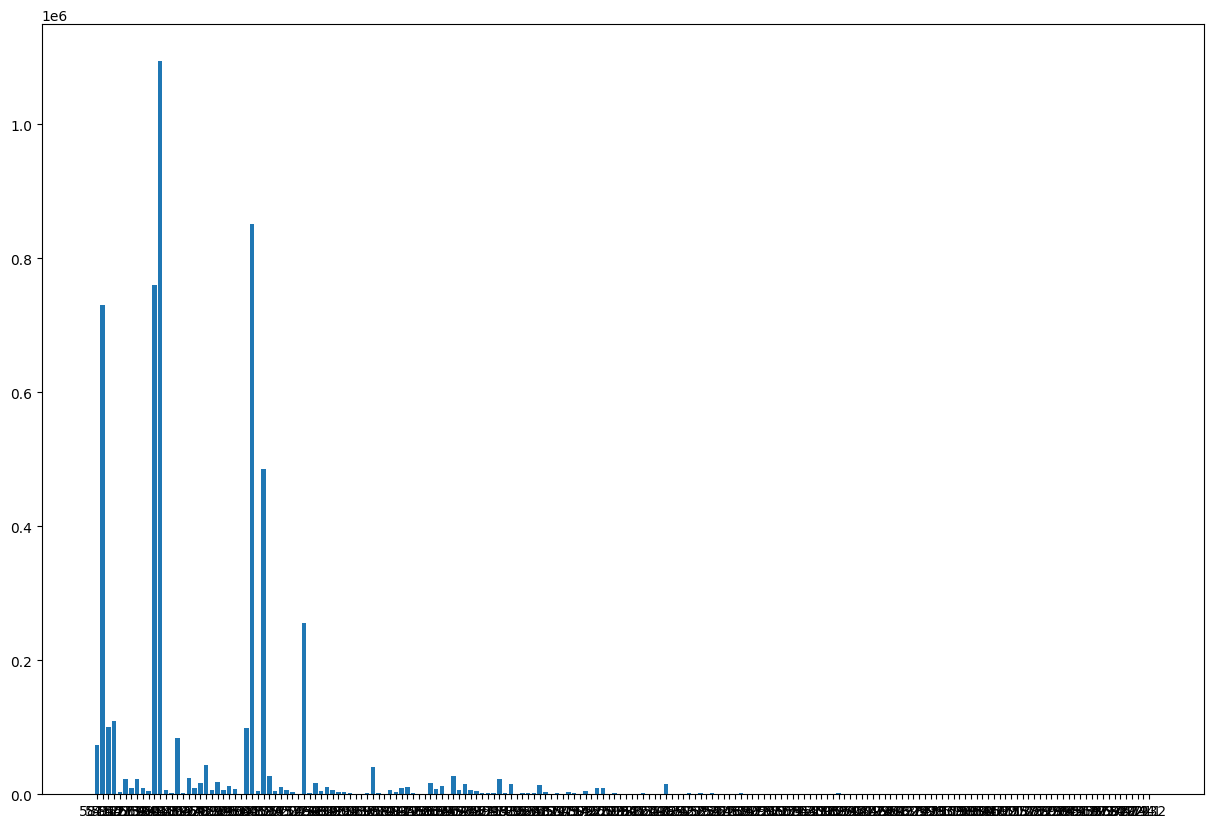

In [23]:
fig,ax = plt.subplots(figsize=(15,10))
ax.bar(out2.keys(),out2.values())

<BarContainer object of 170 artists>

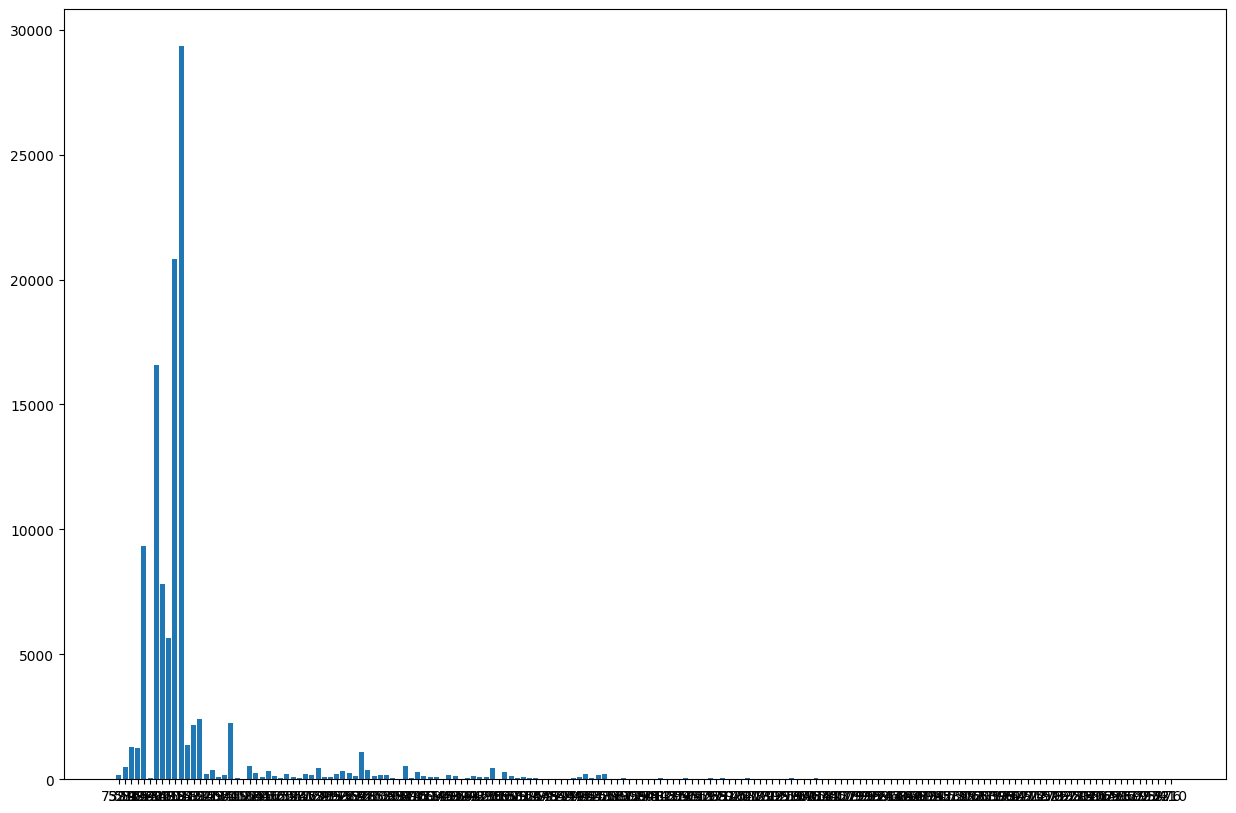

In [24]:
fig,ax = plt.subplots(figsize=(15,10))
ax.bar(out1.keys(),out1.values())

In [25]:
X_train["Data"].to_csv("train.txt", sep='\t', index=False)

In [26]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="accuracy",patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)

In [27]:
with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as f:
    texts = f.read()
    texts = texts.replace('\ufeff', '')  # убираем первый невидимый символ

maxWordsCount =  10
tokenizer = Tokenizer(num_words=maxWordsCount,
                    split=',', char_level=False)
tokenizer.fit_on_texts([texts])

tokenizer.fit_on_texts([texts])


data = tokenizer.texts_to_sequences([texts])
res = to_categorical(data[0], num_classes=maxWordsCount)

inp_words = 30
n = res.shape[0] - inp_words

X = np.array([res[i:i + inp_words, :] for i in range(n)])
Y = res[inp_words:]

model = Sequential()
model.add(InputLayer((inp_words, maxWordsCount),activation=tf.nn.relu))

model.add(SimpleRNN(128,return_sequences=True,activation=tf.nn.relu))
model.add(SimpleRNN(64,activation=tf.nn.relu))


model.add(Dense(maxWordsCount, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.fit(X, Y, batch_size=32, epochs=10,callbacks=[checkpoint_cb,early_stopping_cb])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 128)        │        17,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,794 (120.29 KB)

 Trainable params: 30,794 (120.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1475s 11ms/step - accuracy: 0.4721 - loss: 1.4330
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1556s 11ms/step - accuracy: 0.4781 - loss: 1.4104
Epoch 3/10
139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1544s 11ms/step - accuracy: 0.4791 - loss: 1.4035
Epoch 4/10
139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1524s 11ms/step - accuracy: 0.4792 - loss: 1.4003
Epoch 5/10
139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1545s 11ms/step - accuracy: 0.4790 - loss: 1.4027
Epoch 6/10
139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1550s 11ms/step - accuracy: 0.4795 - loss: 1.3991
Epoch 7/10
139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1544s 11ms/step - accuracy: 0.4723 - loss: 1.5145
Epoch 8/10
139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1592s 11ms/step - accuracy: 0.4786 - loss: 1.4191
Epoch 9/10
139827/139827 ━━━━━━━━━━━━━━━━━━━━ 1561s 11ms/step - accuracy: 0.4790 - loss: 1.4010


In [28]:
len(Y)

4474450

In [29]:
model.save("model62_rnn_2layer_128_64_20tokens_inp40_32batch_15epochs_relu.keras")

In [30]:
def MakePredictions(texts, pred_len=10):
    res=''
    data = tokenizer.texts_to_sequences([texts])[0]
    try:
        for i in range(pred_len):
            x = to_categorical(data[i: i + inp_words], num_classes=maxWordsCount)  # преобразуем в One-Hot-encoding
            inp = x.reshape(1, inp_words, maxWordsCount)

            pred = model.predict(inp)
            indx = pred.argmax(axis=1)[0]
            data.append(indx)

            res += "," + tokenizer.index_word[indx]  # дописываем строку
        res=res[1:]
    except:
        return ['6011' for x in range(10)]
        
    return res


In [31]:
X_test["Data"]=X_test["Data"].apply(lambda x : str(x)[1:-1])

In [32]:
X_test["Preds"]=X_test["Data"].apply(lambda x : MakePredictions(x))
X_test.to_csv("test62RNN.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━